In [47]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import visualization as vis
import importlib
from blackjax.diagnostics import effective_sample_size

In [52]:
# questo serve altrimenti non usa l'ultima versione dei file .py
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(vis)

<module 'visualization' from '/home/ubuntu/MCHMC/visualization.py'>

# Information Theory Project

Allora da quel che mi sembra aver capito, per fare il tuning di L loro usano $n_{eff}^{(i)}$, che calcolano tramite l'autocorrelazione $n_{eff} = \frac{N}{1+2\sum_{t=1}^{\inf}\rho_t}$. Dato che il rumore nella stima delle autocorrelazioni aumenta con t, di solito si tronca la somma per non avere $n_{eff}^{(i)}$ negativi. C'è da sistemare il calcolo seguendo per esempio https://mc-stan.org/docs/reference-manual/analysis.html#effective-sample-size.section .

Quando invece calcolano ESS come metrica per confrontare i diversi algoritmi, lì usano la nozione di $n_{eff}$ legata a $b_2$, ovvero $b_2^2 = 2/n_{eff}$. Settando come target $b_2=0.1$ definiscono $ESS = 200/n$, con n il numero di tagret density evaluation per raggiungere quel valore di $b_2$. Quindi credo che l'idea sarebbe di runnare l'algoritmo non con un numero predefinito di step fino a quando non raggiunge questo threshold.

Miei personalissimi **dubbi**:
- Con target density evaluations non intendono il numero di run teoricamente, ma quante volte viene calcolato il gradiente di L che è la cosa computazionalmente più impegnativa. Dipenderebbe quindi dall'integration scheme: con LF 2 per run, mentre con MN 3 (ogni volta che facciamo update del momento calcoliamo $\nabla L$). Ha senso?
- Nella tabella dove riportano le ESS non mi tornano bene i conti. Esempio: per la Bimodal nel caso migliore abbiamo ESS=0.064 e quindi avremmo n=3125. Non ha senso questa cosa, quando loro stessi scrivono che impiegano $10^7$ runs. Sono confusa.

Cose da **fare**:
- Sistemare calcolo di $n_{eff}^{(i)}$ (*utils.effective_sample_size*)
- Calcolare ESS per confronto algoritmi (tabella che ci interessa)
- Implementare altre funzioni, abbiamo solo bimodal e cauchy (che io direi di lasciare perdere dato che è incasinata)
- Implementare NUTS con NumPyro/PyMC

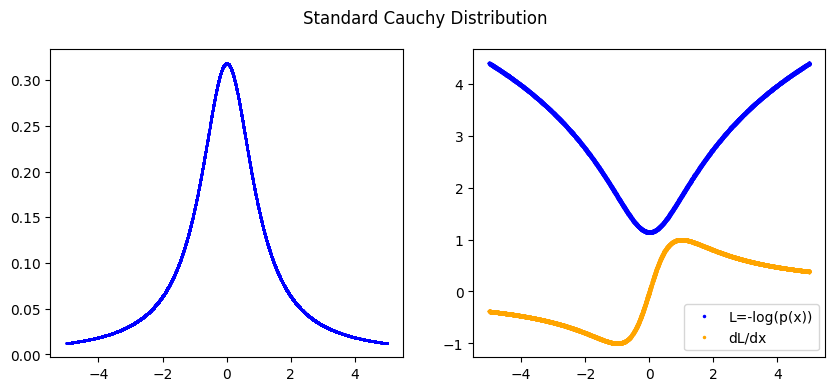

In [28]:
x = np.random.uniform(low=-5, high=5, size=(10000, 1))
L = -np.log(funct.standard_cauchy(x).detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.standard_cauchy).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.standard_cauchy(x).numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Standard Cauchy Distribution')
plt.show()

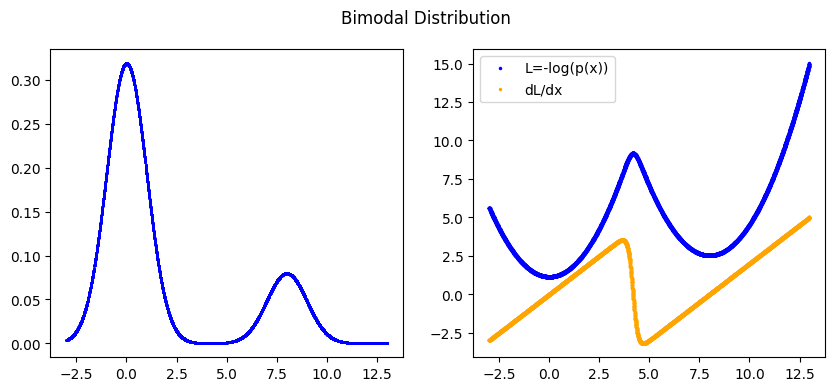

In [29]:
x = np.random.uniform(low=-3, high=13, size=(10000, 1))
L = -np.log(funct.bimodal(x).to("cpu").detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.bimodal).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.bimodal(x).to("cpu").numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Bimodal Distribution')
plt.show()

## Microcanonical Hamiltonian Montecarlo

Let's start with the tuning of $\epsilon$ and L for the bimodal function, it should converge (ma loro hanno fatto $10^7$ steps).

In [27]:
# Optimizing L
N_opt = 10
d = 100
eps_opt = np.sqrt(d) # default
sigma_eff = aut.sigma_eff(d=d, N=500, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces)

L_values = aut.tune_L(sigma_eff, eps_opt, d, N=500, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=N_opt)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 10 iterations of <function MCHMC_bounces at 0x7f1f221efb50> with 500 steps, updating L


Running iterations: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.28s/it]

Optimal L: 9.14866044939058


In [38]:
# Optimizing epsilon
#eps_values, targets = aut.tune_eps(d=100, N=500, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=N_opt)
#epsilon_opt = np.mean(eps_values)
#epsilon_opt = 0.75 * L_opt
print(epsilon_opt)
print(eps_values)


Running 10 iterations of <function MCHMC_bounces at 0x7f1f0e162560> with 500 steps, updating epsilon


Running iterations: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]

0.9852786898612976
[0.93602341 0.90519786 1.08742905 0.96797836 0.96952564 0.90885311
 1.04860616 0.97724855 1.11952722 0.93239754]


In [ ]:
N_grid = 5
N_samples = 20000
dim = 100
n = np.linspace(0.7, 0.8, N_grid)
eps = n * L_opt

gfig, gax = plt.subplots(N_grid, figsize=(4, 3*N_grid))
records = []
for i in tqdm(range(len(eps))):
    e = eps[i]
    gax[i].set_title(rf'$L = {L_opt:.1f}$ $\epsilon = {e:.1f}$')
    try:
        X, *_ = MCHMC.MCHMC_bounces(d=dim, N=N_samples, L=L_opt, epsilon=e, fn=funct.bimodal)
    except ValueError:
        print('CUDA gradient calculation diverges')
    else:
        X = X.to("cpu").detach().numpy()
        x = np.linspace(-20, 20, 10000)
        record = {}
        record['L'] = L_opt
        record['epsilon'] = e
        record['L/e'] = L_opt/e
        gax[i].hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
        gax[i].scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
        gax[i].legend()
        #compute mean, stdev
        record['mean'] = X[:, 0].mean()
        record['std'] = X[:, 0].std()
        #Other metrics??
        records.append(record)
plt.tight_layout()
plt.savefig('grid.svg')
plt.show()

  0%|                                                                                                          | 0/5 [00:00<?, ?it/s]

In [42]:
import pandas as pd
df = pd.DataFrame(records)
df.head(len(df))

,L,epsilon,L/e,mean,std
0,9.14866,6.404062,1.428571,2.447736,3.868504
1,9.14866,6.632779,1.379310,-0.004382,1.024923
2,9.14866,6.861495,1.333333,-0.017182,1.034134
3,9.14866,7.090212,1.290323,0.010431,1.019846
4,9.14866,7.318928,1.250000,-0.047219,1.013604


In [34]:
X, *_ = MCHMC.MCHMC_bounces(d=100, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal, pbar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:33<00:00, 107.09it/s]


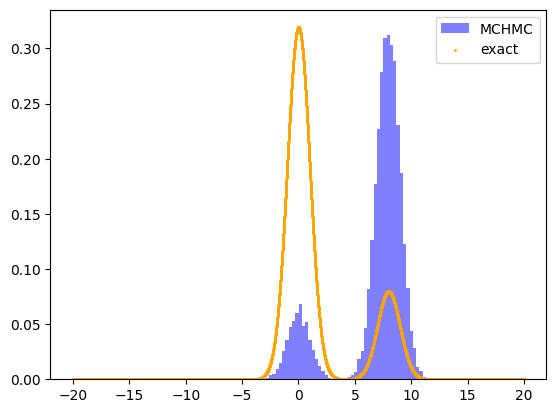

In [35]:
X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

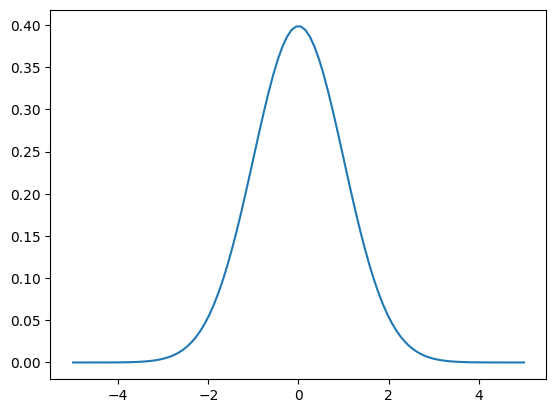

In [187]:
from datetime import date
import jax.numpy as jnp

def logfn(x):
    return jnp.log(funct.jax_bimodal(x, 1))[0]

x = np.linspace(-5, 5, 100)
y = np.array([np.exp(logfn([k]).item()) for k in x])
plt.plot(x, y)

In [198]:
key = jax.random.key(int(date.today().strftime("%Y%m%d")))
subkey = jax.random.split(key)[0]
init = jax.random.uniform(subkey, shape=(100,), minval=-10, maxval=10)
params = aut.blackjax_tuner(logfn, init, key, desired_energy_variance=5e-4, num_steps=20000)

In [199]:
print(f'L = {params.L.item()}')
print(f'epsilon = {params.step_size.item()}')

L = 0.0
epsilon = 0.0


## Langevin-like Hamiltonian Montecarlo

In [37]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=1000, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')


Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating epsilon


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 118.04it/s]

Optimal epsilon: 8.200236320495605


In [38]:
L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating L


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 115.85it/s]


Optimal L: 9.536748886108398


In [39]:
X, *_ = MCLMC.MCLMC(d=1000, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

100%|████████████████████████████████████| 10000/10000 [01:27<00:00, 114.59it/s]


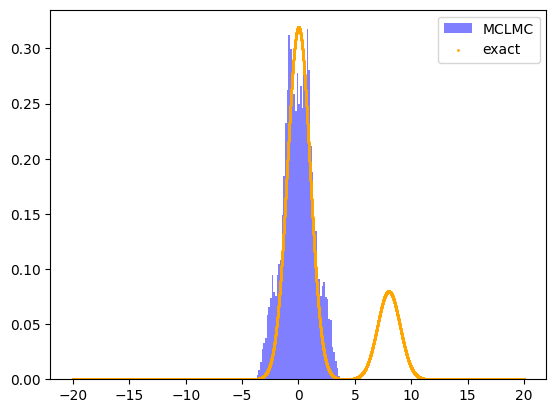

In [40]:
X = X.to("cpu").detach().numpy()

'''
d=1000
mu1 = np.zeros(d)
mu2 = np.full((d,), 8.0 / np.sqrt(d))
separation_axis = mu1-mu2
u = separation_axis / np.norm(separation_axis)
X_proj = samples @ unit_vec
'''

x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [41]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=2, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')

L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating epsilon


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 117.61it/s]


Optimal epsilon: 0.4657119810581207

Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating L


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 111.65it/s]


Optimal L: 16.09433364868164


100%|████████████████████████████████████| 10000/10000 [01:26<00:00, 115.31it/s]


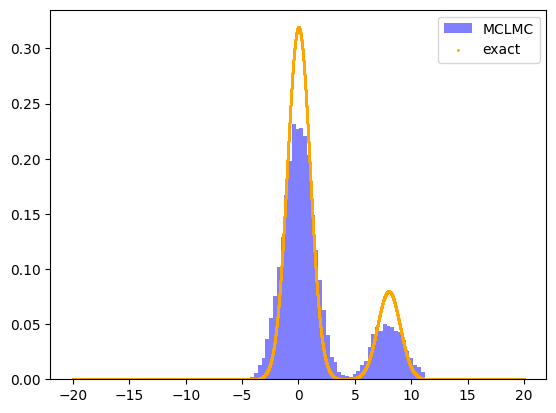

In [42]:
X, *_ = MCLMC.MCLMC(d=2, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

## Naive parameter tuning

To investigate the reasons for the failure to capture the two modes we will do a rough grid search across a few orders of magnitude.

In [10]:
N_grid = 5
N_samples = 25000
dim = 250
eps = np.linspace(15.8, 16.5, N_grid)
L = 1.25*eps
print(L)
print(eps)

[19.75    19.96875 20.1875  20.40625 20.625  ]
[15.8   15.975 16.15  16.325 16.5  ]


100%|████████████████████████████████████| 25000/25000 [03:20<00:00, 124.72it/s]


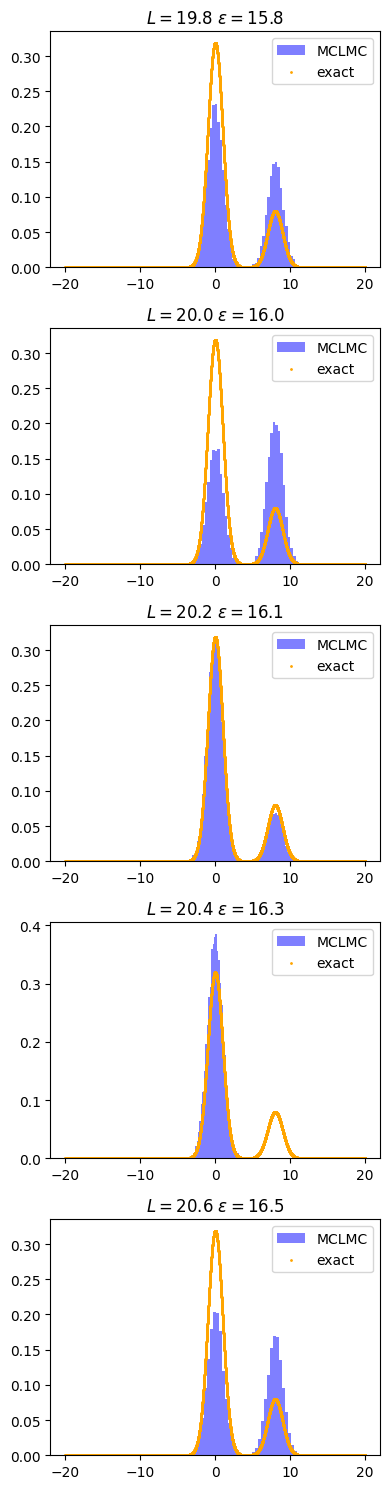

In [11]:
gfig, gax = plt.subplots(N_grid, figsize=(4, 3*N_grid))
records = []
for i in range(len(eps)):
    e = eps[i]
    l = L[i]
    gax[i].set_title(rf'$L = {l:.1f}$ $\epsilon = {e:.1f}$')
    try:
        X, *_ = MCHMC.MCHMC_bounces(d=dim, N=N_samples, L=l, epsilon=e, fn=funct.bimodal)
    except ValueError:
        print('CUDA gradient calculation diverges')
    else:
        X = X.to("cpu").detach().numpy()
        x = np.linspace(-20, 20, 10000)
        record = {}
        record['L'] = l
        record['epsilon'] = e
        gax[i].hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
        gax[i].scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
        gax[i].legend()
        #compute mean, stdev
        record['mean'] = X[:, 0].mean()
        record['std'] = X[:, 0].std()
        #Other metrics??
        records.append(record)
plt.tight_layout()
plt.savefig('grid.svg')
plt.show()

The mean should be $0.2\times 8 = 1.6$ and the standard deviation should be $\approx 3.35$

In [13]:
import pandas as pd
df = pd.DataFrame(records)
df.head(len(df))

,L,epsilon,mean,std
0,19.75000,15.800,3.143504,4.063001
1,19.96875,15.975,4.406536,4.116463
2,20.18750,16.150,1.439851,3.237042
3,20.40625,16.325,-0.015941,1.050970
4,20.62500,16.500,3.592049,4.095265


So $\epsilon = 16.15, \:L = 20.19$ seems to work decently